# Machine learning RFC algorithm to diagnose Acute Compartment Syndrome

## Train classification algorithm

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Train model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset training_three.csv
df = pd.read_csv('/content/drive/MyDrive/SEF 2023-2024/TinyML/interlink_even.csv')

X2 = df[['fsr_1', 'fsr_2','fsr_3','fsr_4', 'fsr_5']]
y2 = df['ground_truth']

# Split data into features (X) and target (y)
X = df[['fsr_1', 'fsr_2','fsr_3','fsr_4', 'fsr_5']]
y = df['ground_truth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1, max_depth =5, max_features='sqrt', class_weight='balanced')

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

y2_pred = clf.predict(X2)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

accuracy = accuracy_score(y, y2_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the model to a file
model_filename = '/content/drive/MyDrive/SEF 2023-2024/TinyML/tinyml_model_interlink.pkl'
joblib.dump(clf, model_filename)
print(f"Model saved to {model_filename}")

Accuracy: 1.0
Accuracy: 0.9951100244498777
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



NameError: name 'joblib' is not defined

Test correct csv data loading if necessary

In [ ]:
print(X_test, y_pred)

     fsr_1  fsr_2  fsr_3  fsr_4  fsr_5
326    671    565    491    443    432
33    2173   2299   2773   2172   1535
15    2112   2229   2493   2991   2014
345    633    528    466    454    395
57    1680   1728   1981   2191   1971
..     ...    ...    ...    ...    ...
82    1777   1889   2225   2115   1889
94    1913   1894   2181   2178   1860
195   1462   1456   1472   1411   1328
310    957   1009    962    960    907
292    945    943    995   1002    918

[74 rows x 5 columns] [1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1]


## Visualize model

Visualize a decision tree in a Random Forest

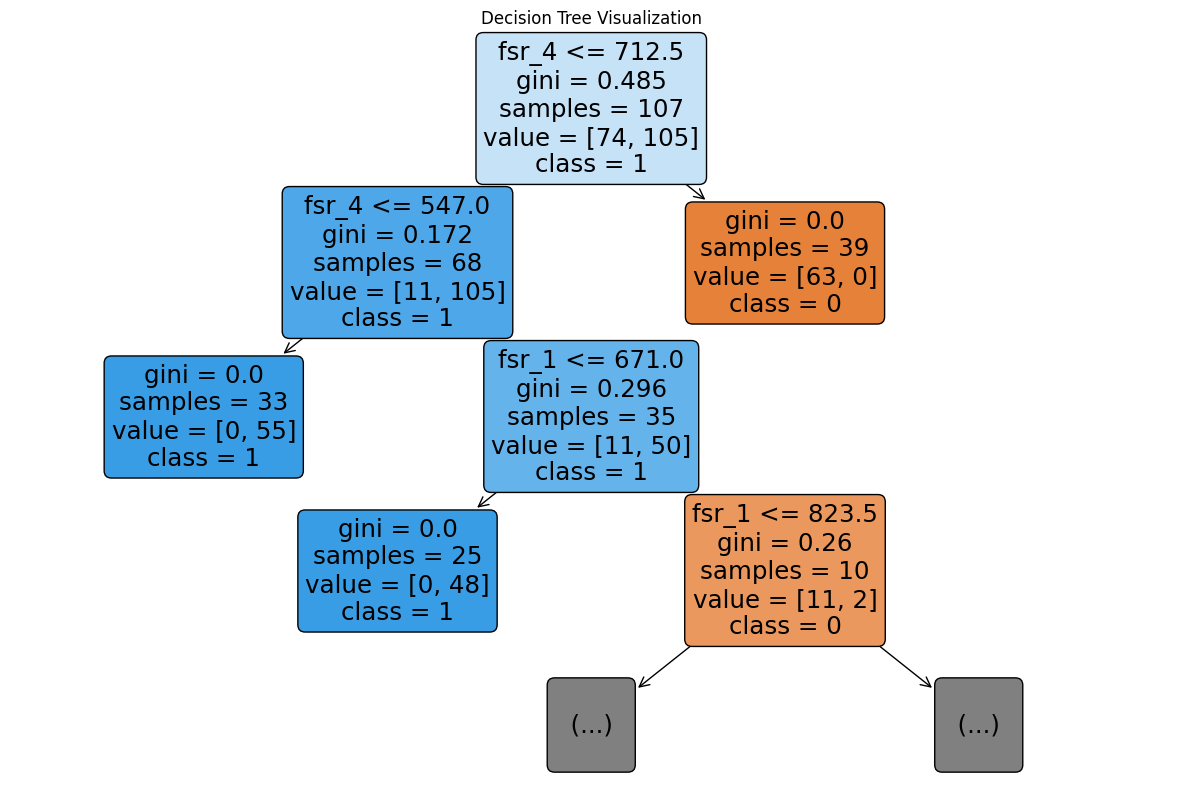

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# You can pick a tree, e.g., the first one (index 0)
tree_to_visualize = clf.estimators_[0]

# Convert class names to strings
class_names_str = [str(class_name) for class_name in clf.classes_]

# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_to_visualize, filled=True, feature_names=X.columns, class_names=class_names_str, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization")

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/decision_tree_RFC_abbreviated_motion.png'
plt.savefig(save_path)

plt.show()

Alternative way to visualize decision tree using graphviz

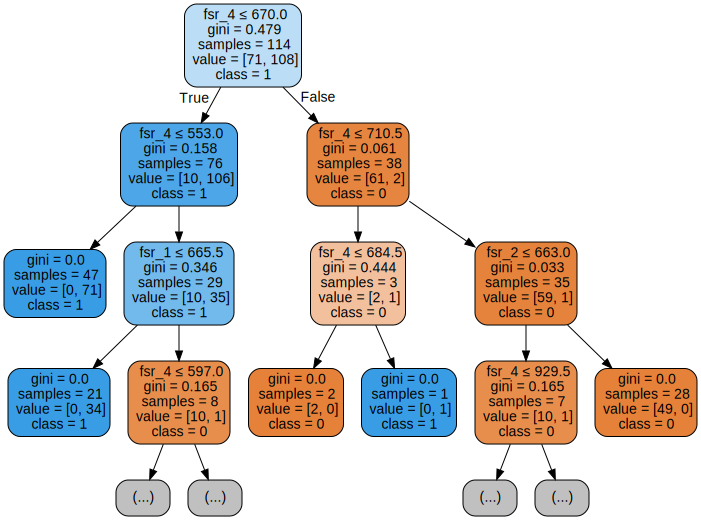

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

# Choose one tree from the RandomForestClassifier
tree = clf.estimators_[5]

# Export the decision tree to DOT format
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X.columns.tolist(),
                           class_names=y.unique().astype(str),
                           filled=True, rounded=True, special_characters=True, max_depth=3)

# Draw graph
graph = graphviz.Source(dot_data, format="png")

# Save the image
save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/decision_tree_RFC_abbreviated_2.png'
graph.render(save_path, format='png', cleanup=True)

# Display the graph (optional)
graph

Visualize feature importance

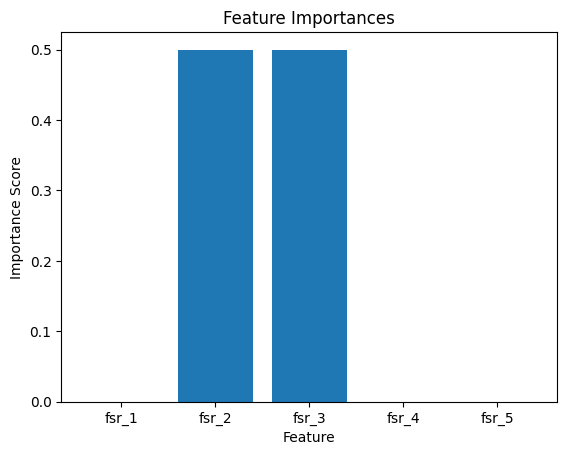

In [ ]:
feature_importances = clf.feature_importances_
plt.bar(X.columns, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importances')

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/feature_importance.png'
plt.savefig(save_path)

plt.show()

ROC Curve

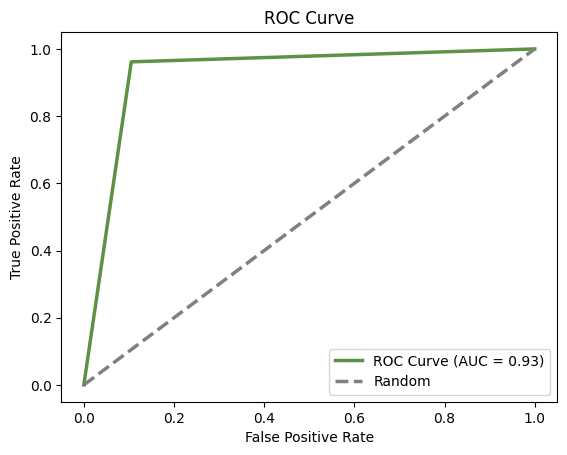

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color = '#5b9243', linewidth = 2.5)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random', linewidth = 2.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Motion Case')
plt.legend()

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/final/ROC_curve_motion.png'
plt.savefig(save_path)

plt.show()

## Generate metrics

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall), specificity, precision, and F1 score
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Check for division by zero
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Check for division by zero
precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Check for division by zero
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0  # Check for division by zero

print(conf_matrix)
print(f"\nAccuracy: {accuracy}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

[[17  2]
 [ 1 25]]

Accuracy: 0.9333333333333333
Sensitivity (Recall): 0.9615384615384616
Specificity: 0.8947368421052632
Precision: 0.9259259259259259
F1 Score: 0.9433962264150944


## Visualize metrics

Save raw metric scores accuracy, sensitivity, specificity, precision, F1 score and confusian matrix to text file


In [ ]:
output_filename = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/data_motion.txt'
with open(output_filename, 'w') as file:
    print("Confusion Matrix:", file=file)
    print(conf_matrix, file=file)
    print(f"\nAccuracy: {accuracy}", file=file)
    print(f"Sensitivity (Recall): {sensitivity}", file=file)
    print(f"Specificity: {specificity}", file=file)
    print(f"Precision: {precision}", file=file)
    print(f"F1 Score: {f1_score}", file=file)

print("saved to file")

saved to file


Confusion Matrix (heat map)

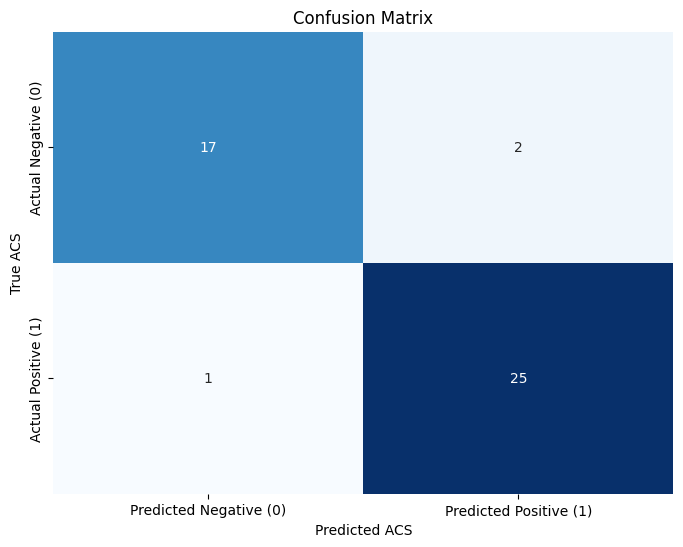

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted ACS')
plt.ylabel('True ACS')

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/final/CM_motion.png'
plt.savefig(save_path)

plt.show()

Metrics (bar chart)

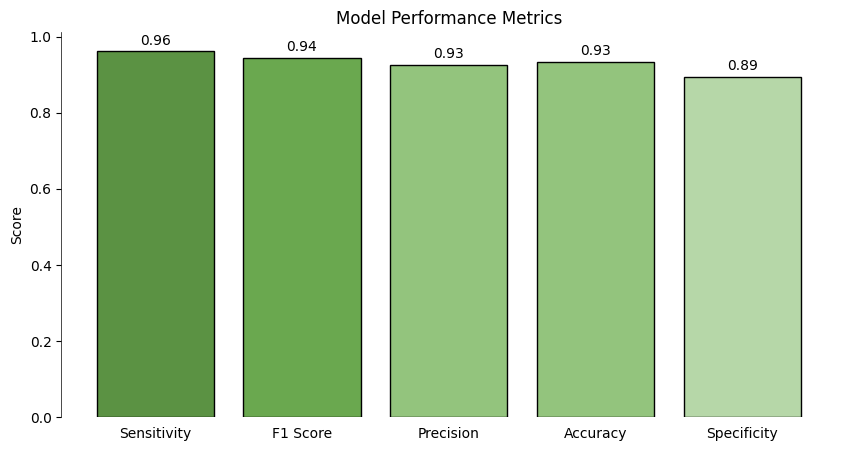

In [ ]:
import matplotlib.pyplot as plt

metrics_names = ['Sensitivity', 'F1 Score', 'Precision', 'Accuracy', 'Specificity']
metrics_values = [sensitivity, f1_score, precision, accuracy, specificity]

plt.figure(figsize=(10, 5))  # Higher = better
bars = plt.bar(metrics_names, metrics_values, color=['#5b9243', '#6aa84f', '#93c47d', '#93c47d', '#b6d7a8'], edgecolor='black')  # Remove borders
plt.title('Model Performance Metrics')
plt.ylabel('Score')

# Add labels to each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Customize y-axis appearance
plt.gca().spines['left'].set_linewidth(0.5)  # Set y-axis line width
plt.gca().spines['right'].set_visible(False)  # Hide x-axis line
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['bottom'].set_visible(False)  # Hide top spine

plt.tick_params(axis='x', bottom=False)


# Set ylim to give some space at the top
plt.ylim(top=max(metrics_values) + 0.05)

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/final/PM_motion.png'
plt.savefig(save_path)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

#bar graph focuse on only relevant metrics
metrics_names = ['Accuracy','Specificity', 'Precision']
metrics_values = [accuracy, specificity, precision]

plt.figure(figsize=(8, 6)) # Higher = better
plt.bar(metrics_names, metrics_values, color=['#df3c5fff', '#6f9bd1ff', '#224193ff']) # Can select other colors
plt.title('Model Performance Metrics')
plt.ylabel('Score')

save_path = '/content/drive/MyDrive/SEF 2023-2024/TinyML/Performance/RFC_model/PM2.png'
plt.savefig(save_path)

plt.show()